In [5]:
import torch
import math
from einops import repeat
import torch.nn as nn


In [6]:
import numpy as np
def hippo_LegS_1(n):
    #will return the hippo-legs matrix used in s4
    A = np.zeros((n,n))
    B = np.array([math.sqrt(2*i+1) for i in range(n)]).reshape(-1,1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i,j] = -(i+1)
            if i < j:
                A[i,j] = 0
            if i > j:
                A[i,j] = -math.sqrt((2*i+1)*(2*j+1))
    return A,B

def hippo_LegS_dplr(n):
    #returns the diagonal-plus-low-rank matrix 
    A_n = np.zeros((n,n))
    P = np.array([math.sqrt(i+1/2) for i in range(n)]).reshape(-1,1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A_n[i,j] = -1/2
            else:
                A_n[i,j] = -math.sqrt((i+1/2)*(j+1/2))
    PPT = P @ P.T
    A = A_n - PPT
    A_d = np.linalg.eigvals(A)
    return A, A_d

def zero_order_hold(A,B,dt):
    da = np.exp(A * dt)
    db = np.dot(np.linalg.inv(A * dt) * (da - np.identity(A.shape[0])), dt*B)
    return da, db

def bilinear(A,B,dt):
    id = np.identity(A.shape[0])
    inv = np.linalg.inv(id - dt * A / 2)
    da = inv @ (id + dt * A / 2)
    db = inv @ B * dt
    return da, db

A,B = hippo_LegS_1(5)
A1,A1_d = hippo_LegS_dplr(5)
print(A)
print(A1)
print(A1_d)

da,db = zero_order_hold(A,B,0.1)
da1,db1 = bilinear(A,B,0.1)


[[-1.          0.          0.          0.          0.        ]
 [-1.73205081 -2.          0.          0.          0.        ]
 [-2.23606798 -3.87298335 -3.          0.          0.        ]
 [-2.64575131 -4.58257569 -5.91607978 -4.          0.        ]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.        ]]
[[-1.         -1.73205081 -2.23606798 -2.64575131 -3.        ]
 [-1.73205081 -2.         -3.87298335 -4.58257569 -5.19615242]
 [-2.23606798 -3.87298335 -3.         -5.91607978 -6.70820393]
 [-2.64575131 -4.58257569 -5.91607978 -4.         -7.93725393]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.        ]]
[-22.25614697   0.10302733   3.52700511   2.37838424   1.24773029]


In [8]:
from einops import einsum
#numpy versions of the code
def discretize(log_dt,log_A_real,A_imag,B):
    #update this to be n-dimensional
    
    dt, A = np.exp(log_dt), -np.exp(log_A_real) + 1j * A_imag

    dtA = einsum(dt,A, 'n, n h -> n h')
    dtB = einsum(dt,B, 'n, n h -> n h')

    dA = (1 + dtA / 2) / (1 - dtA / 2)
    dB = dtB / (1 - dtA/2)

    # dA, dB = (1+dt * A/2) / (1 - dt * A/2), dt * B / (1 - dt * A/2)

    return dA, dB

def nd_s4d(n_inputs,n_states_per_input,dt_min=1e-3,dt_max=1e-1):

    log_dt = np.random.rand(n_inputs) * (np.log(dt_max) - np.log(dt_min)) + np.log(dt_min)
    A = -0.5 + 1j * np.pi * np.arange(n_states_per_input//2)
    A = np.concatenate([A,np.conj(A[::-1])])
    #repeat this across a new dimension for each input
    A = np.repeat(A[np.newaxis,:], n_inputs, axis=0)
    B = np.ones((n_inputs,n_states_per_input)) + 0j
    C = np.random.randn(n_inputs,n_states_per_input) + 1j * np.random.randn(n_inputs,n_states_per_input)
    
    return log_dt, np.log(-A.real), A.imag, B, C


def forward_nd(us,dA,dB,C):
    #num_dimensions is the number of dimensions in the input
    #num_states is the number of dimensions of the SSM per each input
    #us has input (num_dimensions, time (L))
    #dA has shape (num_dimensions, num_states) (diagonal)
    #dB has shape (num_dimensions, num_states)
    #C has shape (num_dimensions, num_states, 1)
    L = us.shape[-1]
    xs = np.zeros((*dA.shape,L),dtype=np.complex128) #num_dimensions, num_states, time
    ys = np.zeros((us.shape[0],L),dtype=np.complex128) #num_dimensions, time)
    inp = einsum(dB,us,'d n, d t -> d n t')
    for i in range(L):
        xs[:,:,i] = dA * xs[:,:,i-1] + inp[:,:,i]
        ys[:,i] = einsum(C,xs[:,:,i],'d n, d n -> d')
    
    return xs, ys.real
    

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from einops import einsum,repeat
import math
import torch

class S4D_rnn(nn.Module):
    #this computes an s4d model 
    def __init__(self,n_inputs,n_states_per_input,dt_min=1e-3,dt_max=1e-1,seed=None,lr=None):
        super().__init__()
        if seed is not None:
            torch.random.seed(seed)

        log_dt = torch.rand(n_inputs) * (math.log(dt_max) - math.log(dt_min)) + np.log(dt_min)
        self.register("log_dt",log_dt,lr)
        
        log_A_real = torch.log(0.5 * torch.ones(n_inputs, n_states_per_input // 2))
        A_imag = math.pi * repeat(torch.arange(n_states_per_input//2), 'n -> h n', h=n_inputs)

        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

        B = torch.ones((n_inputs,n_states_per_input)) + 0j
        self.register("B",B,lr)

        C = torch.rand(n_inputs,n_states_per_input // 2) + 1j * torch.rand(n_inputs,n_states_per_input // 2)
        self.register("C",C,lr)

    def discretize(self,log_dt,log_A_real,A_imag,B):
    
        dt, A = torch.exp(log_dt), -torch.exp(log_A_real) + 1j * A_imag

        dtA = einsum(dt,A, 'n, n h -> n h')
        dtB = einsum(dt,B, 'n, n h -> n h')

        dA = (1 + dtA / 2) / (1 - dtA / 2)
        dB = dtB / (1 - dtA/2)

        return dA, dB

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

    def forward(self,us,rnn=True):
        #num_dimensions is the number of dimensions in the input
        #num_states is the number of dimensions of the SSM per each input
        #us has input (num_dimensions, time (L)) or (batch, num_dim, time)
        #dA has shape (num_dimensions, num_states) (diagonal)
        #dB has shape (num_dimensions, num_states)
        #C has shape (num_dimensions, num_states, 1)
        if len(us.shape) == 2:
            us = us.unsqueeze(0)

        b,nd,L = us.shape
        device = us.device
        #expand A_imag and log_A_real to include complex conjugates (do here so weights are tied)
        A_imag = torch.cat([self.A_imag, -self.A_imag], dim=1)
        #double log_A_real to match
        log_A_real = torch.cat([self.log_A_real, self.log_A_real], dim=1)

        dA, dB = self.discretize(self.log_dt, log_A_real, A_imag, self.B)

        nstates = dA.shape[-1]
        L = us.shape[-1]

        if rnn:
            C = torch.cat([self.C, self.C], dim=1)
            # xs = torch.zeros((b, nd, nstates, L),dtype=torch.complex64) #num_dimensions, num_states, time
            xs = torch.zeros((b, nd,nstates),dtype=torch.complex64).to(device) #num_dimensions, num_states, time
            all_xs = [xs]
            ys = torch.zeros((b, nd, L), dtype=torch.complex64).to(device) #num_dimensions, time)
            inp = einsum(dB,us,'d n, b d t -> b d n t')
            for i in range(L):
                xs = einsum(dA, xs, 'd n, b d n -> b d n') + inp[:,:,:,i]
                all_xs.append(torch.clone(xs))
                ys[:,:,i] = einsum(C,xs,'d n, b d n -> b d')
            
            all_xs = torch.stack(all_xs,dim=-1)

            return all_xs, ys.real

        else:
            #compute the kernel, then convolve
            dt = torch.exp(self.log_dt) # (H)
            # C = torch.view_as_complex(self.C) # (H N)
            C = self.C
            A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

            # Vandermonde multiplication
            dtA = A * dt.unsqueeze(-1)  # (H N)
            K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
            C = C * (torch.exp(dtA)-1.) / A
            #no multiplying by 2 here because we plugged in the conjugate
            k = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

            # Convolution
            k_f = torch.fft.rfft(k, n=2*L) # (H L)
            u_f = torch.fft.rfft(us, n=2*L) # (B H L)
            y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)


            return None, y


(2, 4)
[[0.98122582+0.j         0.97435754+0.11644925j 0.97435754-0.11644925j
  0.98122582+0.j        ]
 [0.99637871+0.j         0.99612036+0.02270907j 0.99612036-0.02270907j
  0.99637871+0.j        ]]
(2, 4, 1000) (2, 1000)


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


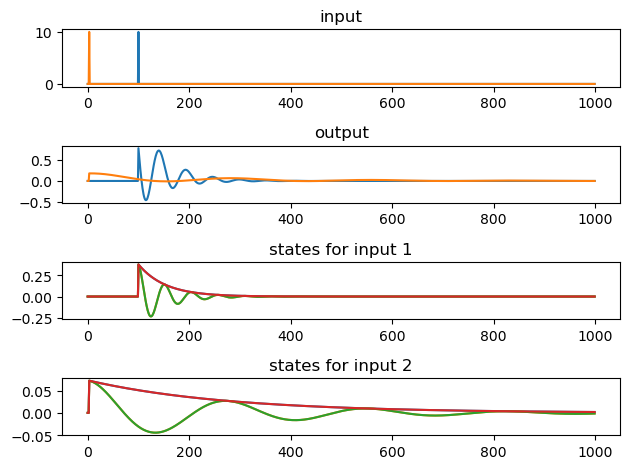

In [58]:
n_inps = 2
log_dts, log_A_reals, A_imags, Bs, Cs = nd_s4d(n_inps,4)
print(Cs.shape)
dA, dB = discretize(log_dts,log_A_reals,A_imags,Bs)
print(dA)
L = 1000
u = np.zeros((n_inps,L))
u[0,100:101] = 10
u[1,3:4] = 10

xs, ys = forward_nd(u,dA,dB,Cs)
print(xs.shape,ys.shape)

def plot_uxy(u,xs,ys):
    if xs is not None:
        fig,ax = plt.subplots(4,1)
    else:
        fig, ax = plt.subplots(2,1)
    ax[0].plot(u.T)
    ax[0].set_title("input")
    ax[1].plot(ys.T)
    ax[1].set_title("output")
    if xs is not None:
        ax[2].set_title("states for input 1")
        ax[2].plot(xs[0].T)
        ax[3].set_title("states for input 2")
        ax[3].plot(xs[1].T)
    plt.tight_layout()

plot_uxy(u,xs,ys)

(2, 1000)


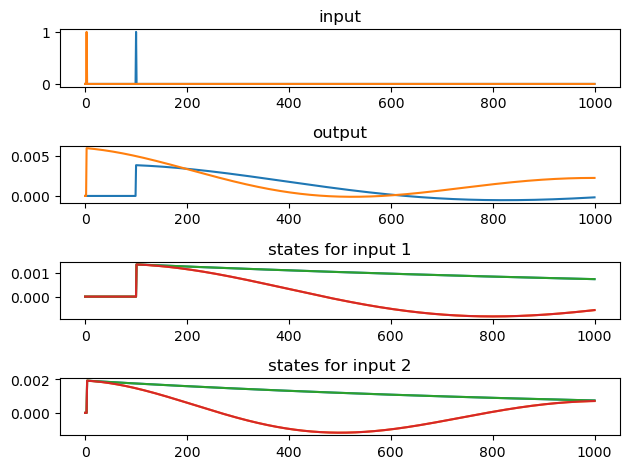

In [59]:
L = 1000
n_inps = 2
u = torch.zeros((n_inps,L))
u[0,100:101] = 1
u[1,3:4] = 1

s4d = S4D_rnn(n_inputs=n_inps,n_states_per_input=4)

xs, ys = s4d(u,rnn=True)

u = u.detach().numpy()
if xs is not None:
    xs = xs.detach().numpy().squeeze()
ys = ys.detach().numpy().squeeze()

print(ys.shape)
plot_uxy(u,xs,ys)

In [69]:
class S4DMinimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        self.s4 = S4D_rnn(n_inputs=d_model,n_states_per_input=d_state)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)
        self.droppout = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_output)
        )

        self.rnn = False

    def forward(self,x):
        u = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
         
        u = u.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        if self.prenorm:
            # Prenorm
            u = self.norm(u.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        xs, ys = self.s4(u,rnn = self.rnn)
        self.ssm_states = xs
        self.ssm_outs = ys

        ys = ys.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)
        u = u.transpose(-1, -2)
        # Residual connection
        zs = ys + u # B, L, d_model

        if not self.prenorm:
            # Postnorm
            zs = self.norm(zs)

        # zs = zs.transpose(-1, -2) # B, d_model, L

        # Decode the outputs
        zs = self.mlp(zs)  # (B, L, d_model) -> (B, L, d_output)

        return zs, xs

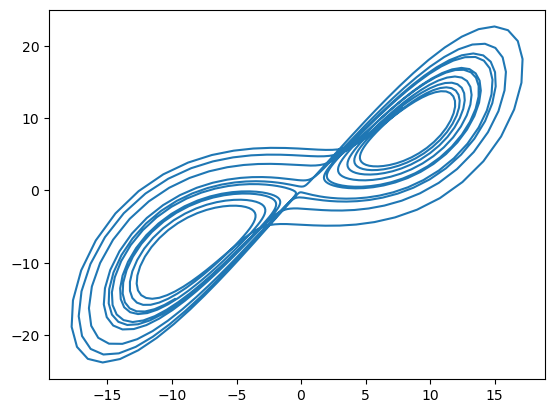

In [14]:
from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.00)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [61]:
from utils import make_dataset,train

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,500,10)


(10, 500, 3) torch.Size([10, 500, 1])
(10, 500, 3) torch.Size([10, 500, 1])


In [65]:
data = next(iter(train_loader))
model = S4DMinimal(1,1,4,10)
model.rnn = True
out,hiddens = model(data)

print(data.shape,out.shape)
print(hiddens.shape)

torch.Size([1, 500, 1]) torch.Size([1, 500, 1]) torch.Size([1, 4, 10, 501])


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


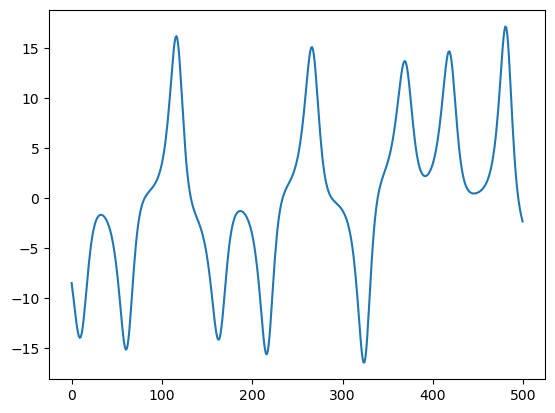

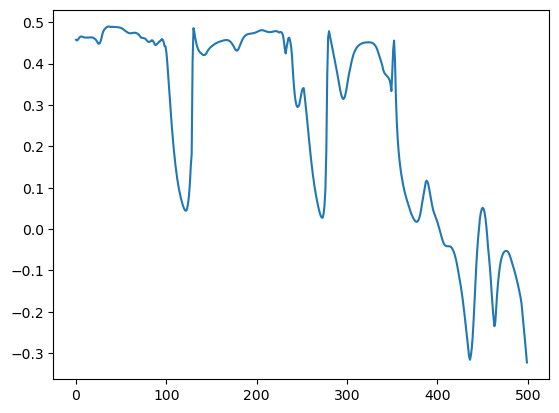

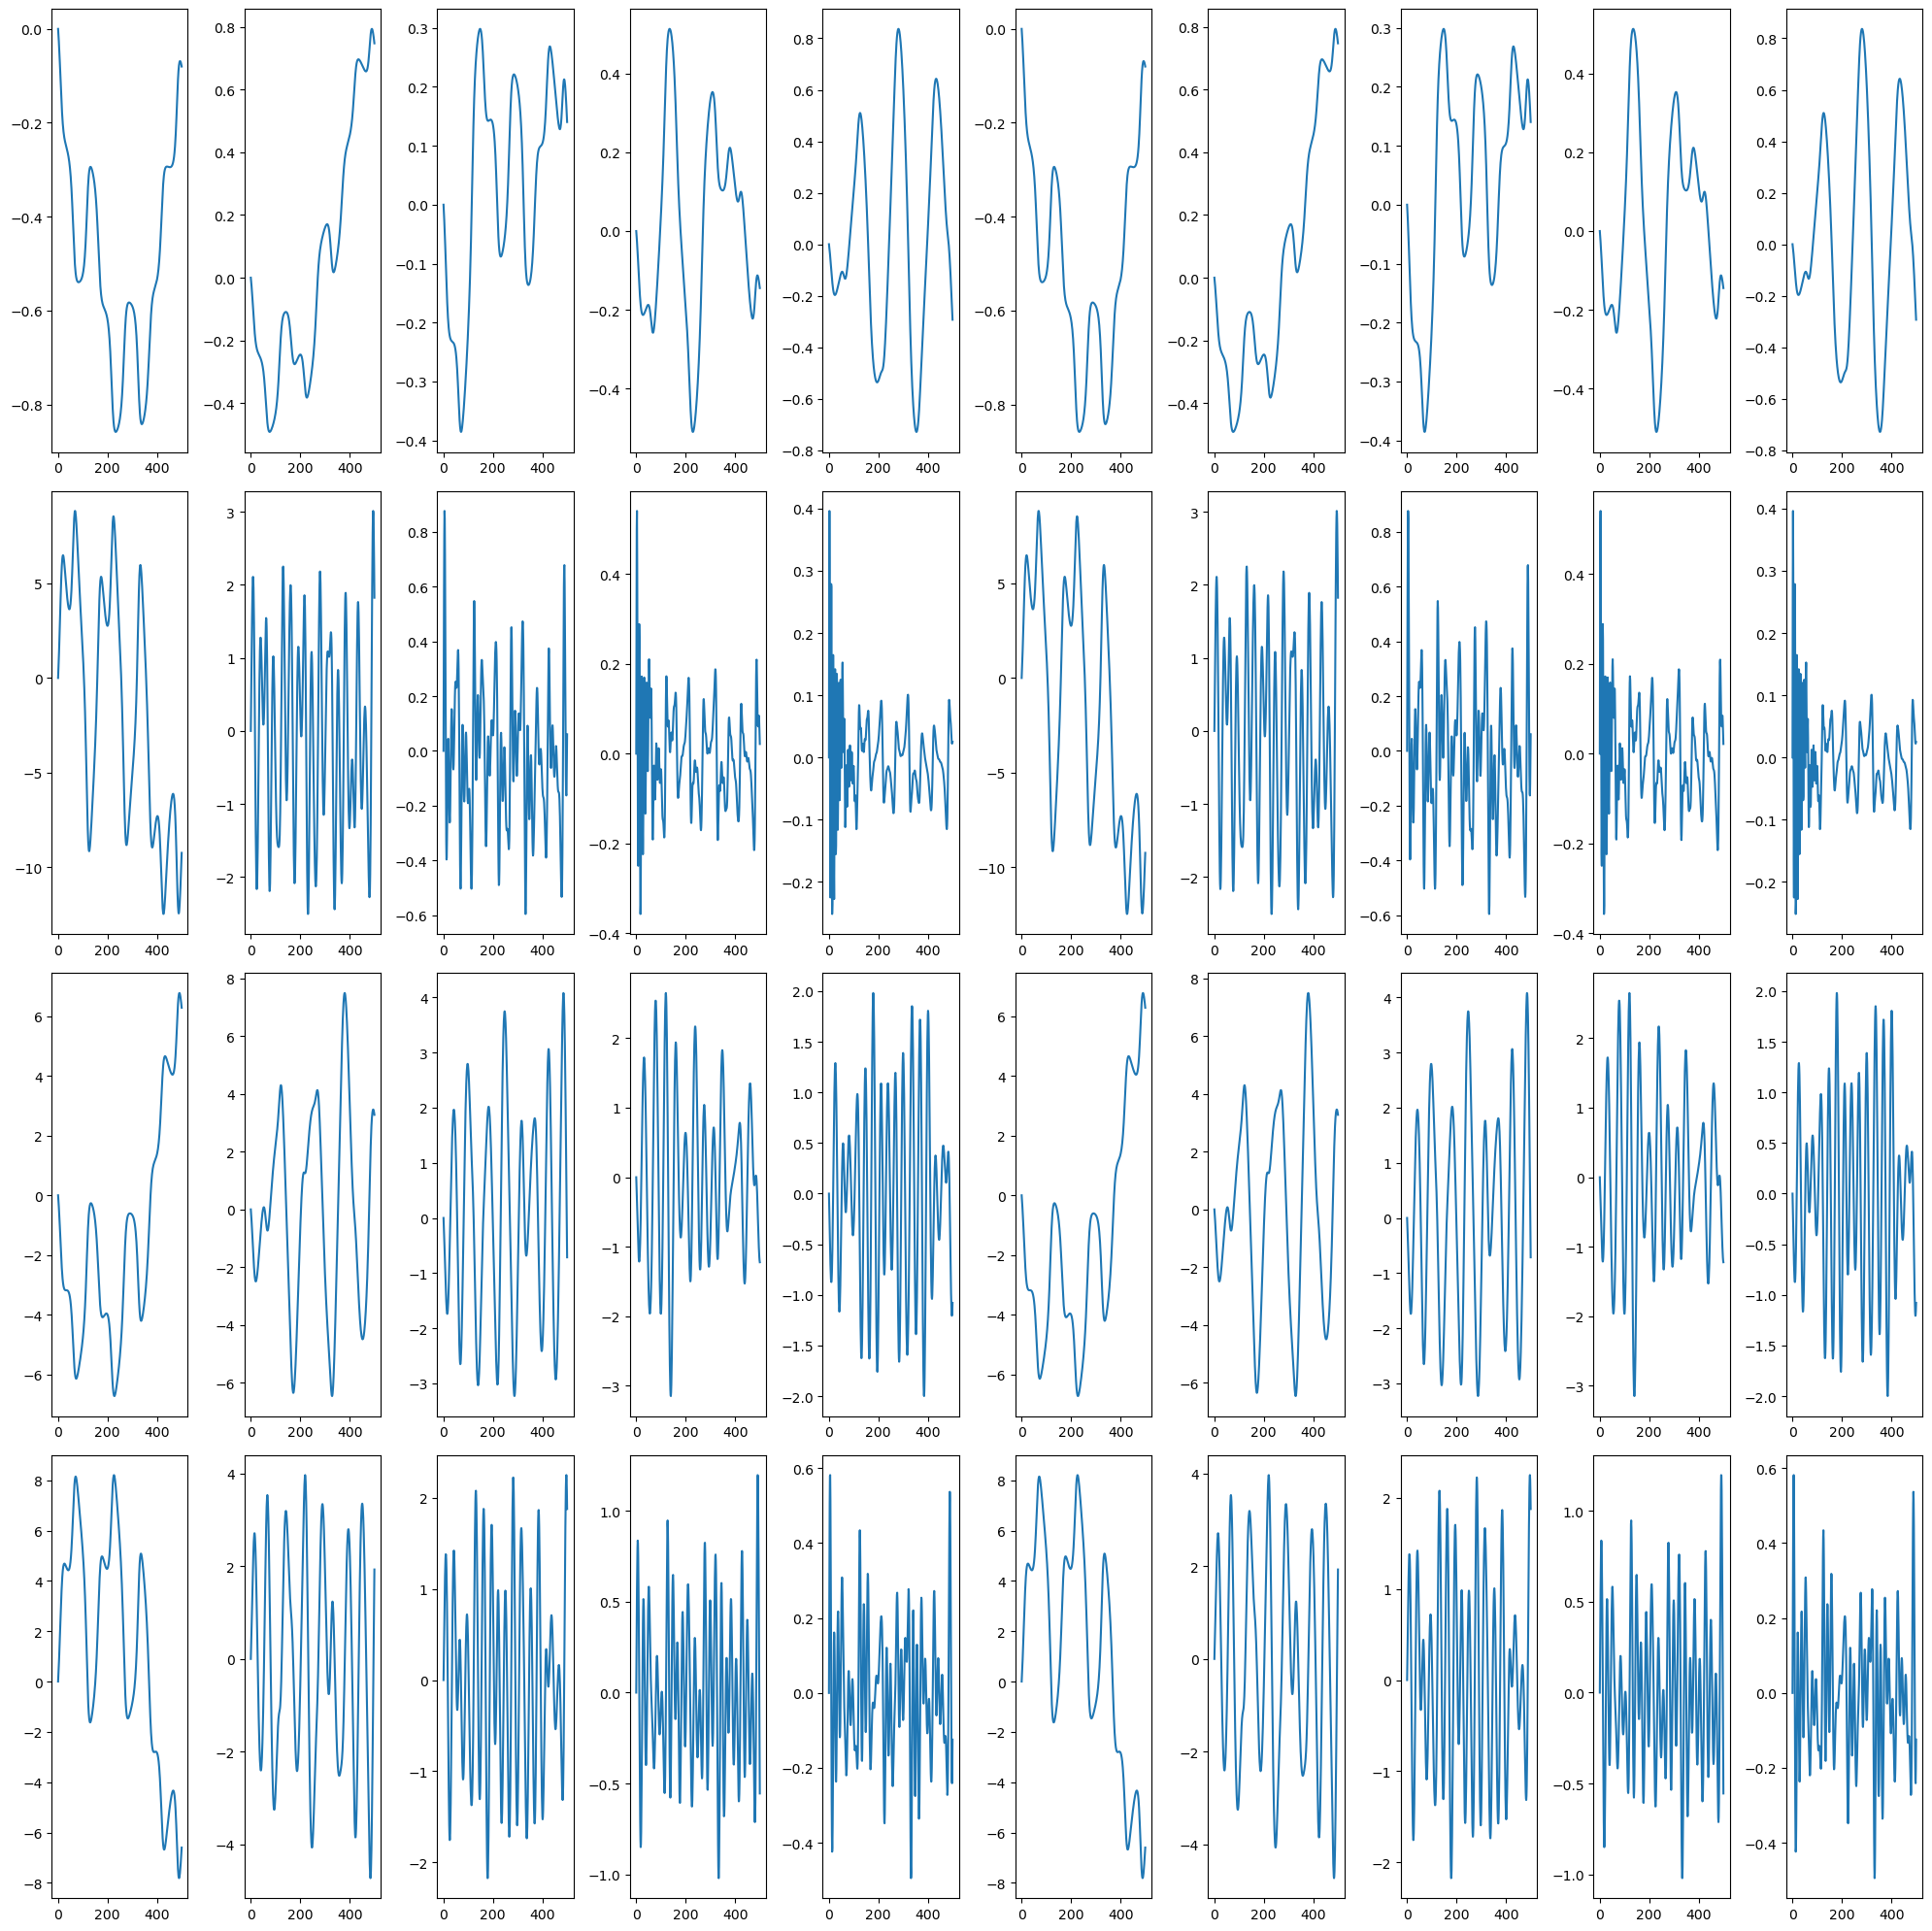

In [66]:


plt.plot(data[0,:,0])
plt.figure()
plt.plot(out[0,:,0].detach().numpy())

fig, ax = plt.subplots(hiddens.shape[1],hiddens.shape[2],figsize=(20,20))
for i in range(hiddens.shape[1]):
    for j in range(hiddens.shape[2]):
        ax[i,j].plot(hiddens[0,i,j].detach().numpy())

plt.tight_layout()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 59.14957847595215


  2%|▏         | 1/50 [00:00<00:34,  1.43it/s]

Epoch 0 Validation Loss: 53.97257347106934
Epoch 1 Training Loss: 47.21952171325684


  4%|▍         | 2/50 [00:01<00:33,  1.45it/s]

Epoch 1 Validation Loss: 40.3172306060791
Epoch 2 Training Loss: 31.12283115386963


  6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

Epoch 2 Validation Loss: 23.267588520050047
Epoch 3 Training Loss: 16.5637797832489


  8%|▊         | 4/50 [00:02<00:31,  1.46it/s]

Epoch 3 Validation Loss: 12.42588667869568
Epoch 4 Training Loss: 9.962270975112915


 10%|█         | 5/50 [00:03<00:30,  1.46it/s]

Epoch 4 Validation Loss: 8.34581904411316
Epoch 5 Training Loss: 7.10771918296814


 12%|█▏        | 6/50 [00:04<00:30,  1.44it/s]

Epoch 5 Validation Loss: 7.13545331954956
Epoch 6 Training Loss: 5.89141879081726


 14%|█▍        | 7/50 [00:05<00:39,  1.10it/s]

Epoch 6 Validation Loss: 6.563866376876831
Epoch 7 Training Loss: 5.1529731273651125


 16%|█▌        | 8/50 [00:06<00:43,  1.04s/it]

Epoch 7 Validation Loss: 5.782786417007446
Epoch 8 Training Loss: 4.626050662994385


 18%|█▊        | 9/50 [00:08<00:50,  1.23s/it]

Epoch 8 Validation Loss: 5.037693929672241
Epoch 9 Training Loss: 3.941797876358032


 20%|██        | 10/50 [00:09<00:49,  1.23s/it]

Epoch 9 Validation Loss: 4.65505576133728
Epoch 10 Training Loss: 3.463698947429657


 22%|██▏       | 11/50 [00:11<00:53,  1.37s/it]

Epoch 10 Validation Loss: 4.042207336425781
Epoch 11 Training Loss: 2.8657268285751343


 24%|██▍       | 12/50 [00:12<00:54,  1.44s/it]

Epoch 11 Validation Loss: 3.659961485862732
Epoch 12 Training Loss: 2.5026788115501404


 26%|██▌       | 13/50 [00:14<00:54,  1.47s/it]

Epoch 12 Validation Loss: 3.2855855345726015
Epoch 13 Training Loss: 2.1835843324661255


 28%|██▊       | 14/50 [00:16<00:54,  1.51s/it]

Epoch 13 Validation Loss: 2.9354963898658752
Epoch 14 Training Loss: 1.9248063564300537


 30%|███       | 15/50 [00:17<00:54,  1.56s/it]

Epoch 14 Validation Loss: 2.693554198741913
Epoch 15 Training Loss: 1.8280673384666444


 32%|███▏      | 16/50 [00:19<00:54,  1.59s/it]

Epoch 15 Validation Loss: 2.449634885787964
Epoch 16 Training Loss: 1.6392689287662505


 34%|███▍      | 17/50 [00:21<00:59,  1.80s/it]

Epoch 16 Validation Loss: 2.178139901161194
Epoch 17 Training Loss: 1.5101935029029847


 36%|███▌      | 18/50 [00:23<00:54,  1.71s/it]

Epoch 17 Validation Loss: 2.071504867076874
Epoch 18 Training Loss: 1.4570602893829345


 38%|███▊      | 19/50 [00:25<00:56,  1.82s/it]

Epoch 18 Validation Loss: 2.0081846952438354
Epoch 19 Training Loss: 1.4157822132110596


 40%|████      | 20/50 [00:27<01:01,  2.06s/it]

Epoch 19 Validation Loss: 1.8773545801639557
Epoch 20 Training Loss: 1.2870384931564331


 42%|████▏     | 21/50 [00:29<00:55,  1.90s/it]

Epoch 20 Validation Loss: 1.7517264842987061
Epoch 21 Training Loss: 1.2744897425174713


 44%|████▍     | 22/50 [00:30<00:48,  1.73s/it]

Epoch 21 Validation Loss: 1.9384731590747832
Epoch 22 Training Loss: 1.3306321859359742


 46%|████▌     | 23/50 [00:32<00:46,  1.71s/it]

Epoch 22 Validation Loss: 1.6659477949142456
Epoch 23 Training Loss: 1.2480757892131806


 48%|████▊     | 24/50 [00:34<00:43,  1.69s/it]

Epoch 23 Validation Loss: 1.5802088856697083
Epoch 24 Training Loss: 1.2241008579730988


 50%|█████     | 25/50 [00:35<00:40,  1.64s/it]

Epoch 24 Validation Loss: 1.5276008367538452
Epoch 25 Training Loss: 1.1238426268100739


 52%|█████▏    | 26/50 [00:36<00:36,  1.52s/it]

Epoch 25 Validation Loss: 1.4657449066638946
Epoch 26 Training Loss: 1.100321650505066


 54%|█████▍    | 27/50 [00:38<00:33,  1.44s/it]

Epoch 26 Validation Loss: 1.46090167760849
Epoch 27 Training Loss: 1.090057373046875


 56%|█████▌    | 28/50 [00:39<00:31,  1.44s/it]

Epoch 27 Validation Loss: 1.3455740988254548
Epoch 28 Training Loss: 1.0029338479042054


 58%|█████▊    | 29/50 [00:40<00:27,  1.32s/it]

Epoch 28 Validation Loss: 1.3178938925266266
Epoch 29 Training Loss: 0.9918217301368714


 60%|██████    | 30/50 [00:41<00:24,  1.24s/it]

Epoch 29 Validation Loss: 1.2925688207149506
Epoch 30 Training Loss: 1.0381238400936126


 62%|██████▏   | 31/50 [00:43<00:24,  1.31s/it]

Epoch 30 Validation Loss: 1.2730056881904601
Epoch 31 Training Loss: 1.0592625975608825


 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

Epoch 31 Validation Loss: 1.2808915615081786
Epoch 32 Training Loss: 0.9944285154342651


 66%|██████▌   | 33/50 [00:45<00:23,  1.35s/it]

Epoch 32 Validation Loss: 1.2181792557239532
Epoch 33 Training Loss: 0.9280556619167328


 68%|██████▊   | 34/50 [00:47<00:21,  1.34s/it]

Epoch 33 Validation Loss: 1.2187942385673523
Epoch 34 Training Loss: 0.9921919524669647


 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

Epoch 34 Validation Loss: 1.4939804673194885
Epoch 35 Training Loss: 1.29729323387146


 72%|███████▏  | 36/50 [00:50<00:19,  1.42s/it]

Epoch 35 Validation Loss: 1.453461503982544
Epoch 36 Training Loss: 1.2296401143074036


 74%|███████▍  | 37/50 [00:52<00:21,  1.62s/it]

Epoch 36 Validation Loss: 1.2822066366672515
Epoch 37 Training Loss: 0.9702782422304154


 76%|███████▌  | 38/50 [00:54<00:21,  1.77s/it]

Epoch 37 Validation Loss: 1.122270441055298
Epoch 38 Training Loss: 0.9054319381713867


 78%|███████▊  | 39/50 [00:56<00:19,  1.76s/it]

Epoch 38 Validation Loss: 1.0337424159049988
Epoch 39 Training Loss: 0.8296539723873139


 80%|████████  | 40/50 [00:57<00:17,  1.74s/it]

Epoch 39 Validation Loss: 1.0571029603481292
Epoch 40 Training Loss: 0.7905771136283875


 82%|████████▏ | 41/50 [00:59<00:15,  1.76s/it]

Epoch 40 Validation Loss: 1.0316308319568634
Epoch 41 Training Loss: 0.8617260158061981


 84%|████████▍ | 42/50 [01:01<00:13,  1.70s/it]

Epoch 41 Validation Loss: 1.000299859046936
Epoch 42 Training Loss: 0.7808097422122955


 86%|████████▌ | 43/50 [01:02<00:12,  1.72s/it]

Epoch 42 Validation Loss: 0.9919021308422089
Epoch 43 Training Loss: 0.7779824256896972


 88%|████████▊ | 44/50 [01:04<00:10,  1.74s/it]

Epoch 43 Validation Loss: 0.9261681258678436
Epoch 44 Training Loss: 0.747375276684761


 90%|█████████ | 45/50 [01:05<00:07,  1.54s/it]

Epoch 44 Validation Loss: 0.9249607741832733
Epoch 45 Training Loss: 0.788654288649559


 92%|█████████▏| 46/50 [01:06<00:05,  1.29s/it]

Epoch 45 Validation Loss: 0.8727760285139083
Epoch 46 Training Loss: 0.7509899795055389


 94%|█████████▍| 47/50 [01:07<00:03,  1.12s/it]

Epoch 46 Validation Loss: 0.8649877548217774
Epoch 47 Training Loss: 0.7195030301809311


 96%|█████████▌| 48/50 [01:07<00:01,  1.02it/s]

Epoch 47 Validation Loss: 0.85990010201931
Epoch 48 Training Loss: 0.7440755605697632


 98%|█████████▊| 49/50 [01:08<00:00,  1.12it/s]

Epoch 48 Validation Loss: 0.8226006597280502
Epoch 49 Training Loss: 0.7216060727834701


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Epoch 49 Validation Loss: 0.8304337322711944


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 0.6685781002044677


  2%|▏         | 1/50 [00:00<00:33,  1.47it/s]

Epoch 0 Validation Loss: 0.8157064408063889
Epoch 1 Training Loss: 0.6555581986904144


  4%|▍         | 2/50 [00:01<00:32,  1.47it/s]

Epoch 1 Validation Loss: 0.8264403343200684
Epoch 2 Training Loss: 0.6442511886358261


  6%|▌         | 3/50 [00:02<00:31,  1.47it/s]

Epoch 2 Validation Loss: 0.7975089490413666
Epoch 3 Training Loss: 0.6455588668584824


  8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

Epoch 3 Validation Loss: 0.7872203767299653
Epoch 4 Training Loss: 0.6375053435564041


 10%|█         | 5/50 [00:03<00:30,  1.47it/s]

Epoch 4 Validation Loss: 0.7931019932031631
Epoch 5 Training Loss: 0.6485270947217942


 12%|█▏        | 6/50 [00:04<00:29,  1.47it/s]

Epoch 5 Validation Loss: 0.8189005196094513
Epoch 6 Training Loss: 0.6457636713981628


 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

Epoch 6 Validation Loss: 0.783934012055397
Epoch 7 Training Loss: 0.6294606477022171


 16%|█▌        | 8/50 [00:05<00:28,  1.47it/s]

Epoch 7 Validation Loss: 0.7956593573093415
Epoch 8 Training Loss: 0.6292872905731202


 18%|█▊        | 9/50 [00:06<00:27,  1.47it/s]

Epoch 8 Validation Loss: 0.792453545331955
Epoch 9 Training Loss: 0.6318404614925385


 20%|██        | 10/50 [00:06<00:27,  1.46it/s]

Epoch 9 Validation Loss: 0.7904593527317048
Epoch 10 Training Loss: 0.6207823425531387


 22%|██▏       | 11/50 [00:07<00:26,  1.46it/s]

Epoch 10 Validation Loss: 0.7840610295534134
Epoch 11 Training Loss: 0.6300563633441925


 24%|██▍       | 12/50 [00:08<00:26,  1.46it/s]

Epoch 11 Validation Loss: 0.7687789469957351
Epoch 12 Training Loss: 0.6247157990932465


 26%|██▌       | 13/50 [00:08<00:25,  1.46it/s]

Epoch 12 Validation Loss: 0.7794554710388184
Epoch 13 Training Loss: 0.6185805559158325


 28%|██▊       | 14/50 [00:09<00:24,  1.46it/s]

Epoch 13 Validation Loss: 0.7687247812747955
Epoch 14 Training Loss: 0.6131398528814316


 30%|███       | 15/50 [00:10<00:24,  1.45it/s]

Epoch 14 Validation Loss: 0.7698640793561935
Epoch 15 Training Loss: 0.6099996447563172


 32%|███▏      | 16/50 [00:10<00:23,  1.45it/s]

Epoch 15 Validation Loss: 0.7649364769458771
Epoch 16 Training Loss: 0.6100687742233276


 34%|███▍      | 17/50 [00:11<00:22,  1.45it/s]

Epoch 16 Validation Loss: 0.7594852685928345
Epoch 17 Training Loss: 0.6103761196136475


 36%|███▌      | 18/50 [00:12<00:22,  1.45it/s]

Epoch 17 Validation Loss: 0.7466943770647049
Epoch 18 Training Loss: 0.608073154091835


 38%|███▊      | 19/50 [00:12<00:21,  1.46it/s]

Epoch 18 Validation Loss: 0.7656962543725967
Epoch 19 Training Loss: 0.6104108542203903


 40%|████      | 20/50 [00:13<00:20,  1.46it/s]

Epoch 19 Validation Loss: 0.7504566937685013
Epoch 20 Training Loss: 0.6026495069265365


 42%|████▏     | 21/50 [00:14<00:19,  1.46it/s]

Epoch 20 Validation Loss: 0.751975667476654
Epoch 21 Training Loss: 0.5972270756959915


 44%|████▍     | 22/50 [00:15<00:19,  1.47it/s]

Epoch 21 Validation Loss: 0.7472582638263703
Epoch 22 Training Loss: 0.5971515774726868


 46%|████▌     | 23/50 [00:15<00:18,  1.47it/s]

Epoch 22 Validation Loss: 0.7501619815826416
Epoch 23 Training Loss: 0.5943780422210694


 48%|████▊     | 24/50 [00:16<00:17,  1.47it/s]

Epoch 23 Validation Loss: 0.7456704914569855
Epoch 24 Training Loss: 0.5923542082309723


 50%|█████     | 25/50 [00:17<00:17,  1.47it/s]

Epoch 24 Validation Loss: 0.7351368695497513
Epoch 25 Training Loss: 0.5913266897201538


 52%|█████▏    | 26/50 [00:17<00:16,  1.47it/s]

Epoch 25 Validation Loss: 0.7353090792894363
Epoch 26 Training Loss: 0.5905203700065613


 54%|█████▍    | 27/50 [00:18<00:15,  1.47it/s]

Epoch 26 Validation Loss: 0.7237052708864212
Epoch 27 Training Loss: 0.5845083653926849


 56%|█████▌    | 28/50 [00:19<00:15,  1.47it/s]

Epoch 27 Validation Loss: 0.72400783598423
Epoch 28 Training Loss: 0.5866602808237076


 58%|█████▊    | 29/50 [00:19<00:14,  1.47it/s]

Epoch 28 Validation Loss: 0.7288401156663895
Epoch 29 Training Loss: 0.5852072060108184


 60%|██████    | 30/50 [00:20<00:13,  1.47it/s]

Epoch 29 Validation Loss: 0.7196524322032929
Epoch 30 Training Loss: 0.5912631154060364


 62%|██████▏   | 31/50 [00:21<00:12,  1.47it/s]

Epoch 30 Validation Loss: 0.7297648847103119
Epoch 31 Training Loss: 0.5827765196561814


 64%|██████▍   | 32/50 [00:21<00:12,  1.47it/s]

Epoch 31 Validation Loss: 0.712374421954155
Epoch 32 Training Loss: 0.5770000904798508


 66%|██████▌   | 33/50 [00:22<00:11,  1.47it/s]

Epoch 32 Validation Loss: 0.7146750599145889
Epoch 33 Training Loss: 0.5766183435916901


 68%|██████▊   | 34/50 [00:23<00:10,  1.47it/s]

Epoch 33 Validation Loss: 0.7152143061161041
Epoch 34 Training Loss: 0.5744723379611969


 70%|███████   | 35/50 [00:23<00:10,  1.47it/s]

Epoch 34 Validation Loss: 0.7072860330343247
Epoch 35 Training Loss: 0.5695139199495316


 72%|███████▏  | 36/50 [00:24<00:09,  1.47it/s]

Epoch 35 Validation Loss: 0.712931290268898
Epoch 36 Training Loss: 0.5709774643182755


 74%|███████▍  | 37/50 [00:25<00:08,  1.47it/s]

Epoch 36 Validation Loss: 0.7076856583356858
Epoch 37 Training Loss: 0.575066989660263


 76%|███████▌  | 38/50 [00:25<00:08,  1.47it/s]

Epoch 37 Validation Loss: 0.7121288120746613
Epoch 38 Training Loss: 0.5773422539234161


 78%|███████▊  | 39/50 [00:26<00:07,  1.47it/s]

Epoch 38 Validation Loss: 0.6887527167797088
Epoch 39 Training Loss: 0.5716843754053116


 80%|████████  | 40/50 [00:27<00:06,  1.47it/s]

Epoch 39 Validation Loss: 0.7126357585191727
Epoch 40 Training Loss: 0.563306325674057


 82%|████████▏ | 41/50 [00:27<00:06,  1.47it/s]

Epoch 40 Validation Loss: 0.6979685366153717
Epoch 41 Training Loss: 0.5626702010631561


 84%|████████▍ | 42/50 [00:28<00:05,  1.47it/s]

Epoch 41 Validation Loss: 0.6882726699113846
Epoch 42 Training Loss: 0.5648744195699692


 86%|████████▌ | 43/50 [00:29<00:04,  1.46it/s]

Epoch 42 Validation Loss: 0.7107789427042007
Epoch 43 Training Loss: 0.5652807593345642


 88%|████████▊ | 44/50 [00:30<00:04,  1.46it/s]

Epoch 43 Validation Loss: 0.6814465880393982
Epoch 44 Training Loss: 0.5561481922864914


 90%|█████████ | 45/50 [00:30<00:03,  1.46it/s]

Epoch 44 Validation Loss: 0.6952843010425568
Epoch 45 Training Loss: 0.5553197592496872


 92%|█████████▏| 46/50 [00:31<00:02,  1.46it/s]

Epoch 45 Validation Loss: 0.6915830612182617
Epoch 46 Training Loss: 0.5526575118303299


 94%|█████████▍| 47/50 [00:32<00:02,  1.44it/s]

Epoch 46 Validation Loss: 0.6866433888673782
Epoch 47 Training Loss: 0.552392092347145


 96%|█████████▌| 48/50 [00:32<00:01,  1.45it/s]

Epoch 47 Validation Loss: 0.6763649165630341
Epoch 48 Training Loss: 0.5535679578781127


 98%|█████████▊| 49/50 [00:33<00:00,  1.45it/s]

Epoch 48 Validation Loss: 0.6760203957557678
Epoch 49 Training Loss: 0.5489576876163482


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch 49 Validation Loss: 0.6769868463277817


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 4.03476493358612


  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

Epoch 0 Validation Loss: 1.0475491523742675
Epoch 1 Training Loss: 3.73051233291626


  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

Epoch 1 Validation Loss: 1.551620602607727
Epoch 2 Training Loss: 3.483634090423584


  6%|▌         | 3/50 [00:04<01:08,  1.47s/it]

Epoch 2 Validation Loss: 0.9216660887002945
Epoch 3 Training Loss: 2.8045366048812865


  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

Epoch 3 Validation Loss: 1.1252701878547668
Epoch 4 Training Loss: 2.523168885707855


 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

Epoch 4 Validation Loss: 1.0118717402219772
Epoch 5 Training Loss: 2.534339463710785


 12%|█▏        | 6/50 [00:08<01:01,  1.41s/it]

Epoch 5 Validation Loss: 1.413177067041397
Epoch 6 Training Loss: 2.7385153770446777


 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

Epoch 6 Validation Loss: 0.9356033742427826
Epoch 7 Training Loss: 2.6698020815849306


 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

Epoch 7 Validation Loss: 1.192022430896759
Epoch 8 Training Loss: 2.597913908958435


 18%|█▊        | 9/50 [00:12<00:56,  1.39s/it]

Epoch 8 Validation Loss: 1.076962161064148
Epoch 9 Training Loss: 3.098670279979706


 20%|██        | 10/50 [00:14<00:55,  1.38s/it]

Epoch 9 Validation Loss: 1.1001877695322038
Epoch 10 Training Loss: 2.5898627400398255


 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

Epoch 10 Validation Loss: 1.2017823815345765
Epoch 11 Training Loss: 2.3895939111709597


 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

Epoch 11 Validation Loss: 1.104726842045784
Epoch 12 Training Loss: 2.2969136476516723


 26%|██▌       | 13/50 [00:18<00:51,  1.38s/it]

Epoch 12 Validation Loss: 1.072125318646431
Epoch 13 Training Loss: 2.3587738275527954


 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

Epoch 13 Validation Loss: 0.972163787484169
Epoch 14 Training Loss: 2.282198441028595


 30%|███       | 15/50 [00:21<00:51,  1.48s/it]

Epoch 14 Validation Loss: 1.0531586289405823
Epoch 15 Training Loss: 2.223625588417053


 32%|███▏      | 16/50 [00:22<00:49,  1.45s/it]

Epoch 15 Validation Loss: 0.9624512434005738
Epoch 16 Training Loss: 2.112095075845718


 34%|███▍      | 17/50 [00:23<00:47,  1.43s/it]

Epoch 16 Validation Loss: 1.0781203031539917
Epoch 17 Training Loss: 2.1035039246082308


 36%|███▌      | 18/50 [00:25<00:45,  1.41s/it]

Epoch 17 Validation Loss: 1.0009765297174453
Epoch 18 Training Loss: 2.022672736644745


 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

Epoch 18 Validation Loss: 1.1159084647893907
Epoch 19 Training Loss: 2.3488322257995606


 40%|████      | 20/50 [00:28<00:41,  1.39s/it]

Epoch 19 Validation Loss: 1.0100144922733307
Epoch 20 Training Loss: 2.2376129269599914


 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

Epoch 20 Validation Loss: 1.3653474926948548
Epoch 21 Training Loss: 2.678187298774719


 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

Epoch 21 Validation Loss: 1.2082132160663606
Epoch 22 Training Loss: 2.2995322227478026


 46%|████▌     | 23/50 [00:32<00:37,  1.38s/it]

Epoch 22 Validation Loss: 1.0512976229190827
Epoch 23 Training Loss: 2.9589779496192934


 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

Epoch 23 Validation Loss: 1.0735574424266816
Epoch 24 Training Loss: 3.765336048603058


 50%|█████     | 25/50 [00:35<00:35,  1.43s/it]

Epoch 24 Validation Loss: 1.351842647790909
Epoch 25 Training Loss: 2.500228202342987


 52%|█████▏    | 26/50 [00:36<00:34,  1.43s/it]

Epoch 25 Validation Loss: 1.1583103239536285
Epoch 26 Training Loss: 2.4770400881767274


 54%|█████▍    | 27/50 [00:37<00:32,  1.41s/it]

Epoch 26 Validation Loss: 1.2552520751953125
Epoch 27 Training Loss: 2.257116138935089


 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

Epoch 27 Validation Loss: 0.9213848233222961
Epoch 28 Training Loss: 2.179681646823883


 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

Epoch 28 Validation Loss: 1.3878472924232483
Epoch 29 Training Loss: 2.1763245165348053


 60%|██████    | 30/50 [00:42<00:27,  1.39s/it]

Epoch 29 Validation Loss: 0.8851436853408814
Epoch 30 Training Loss: 1.9825774312019349


 62%|██████▏   | 31/50 [00:43<00:28,  1.50s/it]

Epoch 30 Validation Loss: 1.066855451464653
Epoch 31 Training Loss: 2.0246676921844484


 64%|██████▍   | 32/50 [00:45<00:26,  1.46s/it]

Epoch 31 Validation Loss: 1.0022584319114685
Epoch 32 Training Loss: 1.9817904591560365


 66%|██████▌   | 33/50 [00:46<00:24,  1.44s/it]

Epoch 32 Validation Loss: 0.9269586056470871
Epoch 33 Training Loss: 1.9337583899497985


 68%|██████▊   | 34/50 [00:48<00:22,  1.42s/it]

Epoch 33 Validation Loss: 0.9286579221487046
Epoch 34 Training Loss: 2.0724727272987367


 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

Epoch 34 Validation Loss: 0.9236157536506653
Epoch 35 Training Loss: 1.9077924549579621


 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

Epoch 35 Validation Loss: 0.9539407700300216
Epoch 36 Training Loss: 1.8963194727897643


 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

Epoch 36 Validation Loss: 1.0062921583652495
Epoch 37 Training Loss: 1.9978931248188019


 76%|███████▌  | 38/50 [00:53<00:16,  1.39s/it]

Epoch 37 Validation Loss: 0.9234358072280884
Epoch 38 Training Loss: 1.8210154592990875


 78%|███████▊  | 39/50 [00:54<00:15,  1.39s/it]

Epoch 38 Validation Loss: 1.0607483088970184
Epoch 39 Training Loss: 2.2055718421936037


 80%|████████  | 40/50 [00:56<00:13,  1.39s/it]

Epoch 39 Validation Loss: 0.975999367237091
Epoch 40 Training Loss: 2.08036687374115


 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

Epoch 40 Validation Loss: 0.9968275964260102
Epoch 41 Training Loss: 2.3025763869285583


 84%|████████▍ | 42/50 [00:59<00:11,  1.45s/it]

Epoch 41 Validation Loss: 1.3076966643333434
Epoch 42 Training Loss: 1.8668190777301787


 86%|████████▌ | 43/50 [01:00<00:10,  1.43s/it]

Epoch 42 Validation Loss: 0.8440381795167923
Epoch 43 Training Loss: 1.8787151157855988


 88%|████████▊ | 44/50 [01:02<00:08,  1.42s/it]

Epoch 43 Validation Loss: 1.0300629049539567
Epoch 44 Training Loss: 1.8142965137958527


 90%|█████████ | 45/50 [01:03<00:07,  1.41s/it]

Epoch 44 Validation Loss: 0.8638772815465927
Epoch 45 Training Loss: 1.8353290796279906


 92%|█████████▏| 46/50 [01:04<00:05,  1.40s/it]

Epoch 45 Validation Loss: 0.824689844250679
Epoch 46 Training Loss: 1.8245528399944306


 94%|█████████▍| 47/50 [01:06<00:04,  1.40s/it]

Epoch 46 Validation Loss: 0.8594500094652175
Epoch 47 Training Loss: 1.7484834432601928


 96%|█████████▌| 48/50 [01:07<00:02,  1.40s/it]

Epoch 47 Validation Loss: 0.8301549971103668
Epoch 48 Training Loss: 1.938204151391983


 98%|█████████▊| 49/50 [01:09<00:01,  1.39s/it]

Epoch 48 Validation Loss: 0.9938814550638199
Epoch 49 Training Loss: 1.9090510189533234


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


Epoch 49 Validation Loss: 0.8377382099628449


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 1.7467566192150117


  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

Epoch 0 Validation Loss: 0.9193881809711456
Epoch 1 Training Loss: 1.6607615172863006


  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

Epoch 1 Validation Loss: 0.8489385694265366
Epoch 2 Training Loss: 1.6036488175392152


  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

Epoch 2 Validation Loss: 0.8142902612686157
Epoch 3 Training Loss: 1.601856791973114


  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

Epoch 3 Validation Loss: 0.8275994777679443
Epoch 4 Training Loss: 1.625704425573349


 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

Epoch 4 Validation Loss: 0.8706310033798218
Epoch 5 Training Loss: 1.586895602941513


 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

Epoch 5 Validation Loss: 0.8026554197072983
Epoch 6 Training Loss: 1.584906530380249


 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

Epoch 6 Validation Loss: 0.8190755516290664
Epoch 7 Training Loss: 1.5900826573371887


 16%|█▌        | 8/50 [00:11<00:57,  1.37s/it]

Epoch 7 Validation Loss: 0.8050091445446015
Epoch 8 Training Loss: 1.5777454555034638


 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

Epoch 8 Validation Loss: 0.8367154270410537
Epoch 9 Training Loss: 1.5843163073062896


 20%|██        | 10/50 [00:13<00:57,  1.43s/it]

Epoch 9 Validation Loss: 0.8161606013774871
Epoch 10 Training Loss: 1.57921404838562


 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

Epoch 10 Validation Loss: 0.8057882964611054
Epoch 11 Training Loss: 1.5751697540283203


 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

Epoch 11 Validation Loss: 0.8075330436229706
Epoch 12 Training Loss: 1.5738842487335205


 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

Epoch 12 Validation Loss: 0.8020074814558029
Epoch 13 Training Loss: 1.5706414341926576


 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

Epoch 13 Validation Loss: 0.8222486793994903
Epoch 14 Training Loss: 1.5661698877811432


 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

Epoch 14 Validation Loss: 0.8139315932989121
Epoch 15 Training Loss: 1.5663363695144654


 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

Epoch 15 Validation Loss: 0.7929663896560669
Epoch 16 Training Loss: 1.564507919549942


 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

Epoch 16 Validation Loss: 0.8051127284765244
Epoch 17 Training Loss: 1.5882135391235352


 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

Epoch 17 Validation Loss: 0.8025989234447479
Epoch 18 Training Loss: 1.5625163614749908


 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

Epoch 18 Validation Loss: 0.7887997299432754
Epoch 19 Training Loss: 1.554000771045685


 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

Epoch 19 Validation Loss: 0.8024307012557983
Epoch 20 Training Loss: 1.578182590007782


 42%|████▏     | 21/50 [00:29<00:40,  1.38s/it]

Epoch 20 Validation Loss: 0.8035001307725906
Epoch 21 Training Loss: 1.57697092294693


 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

Epoch 21 Validation Loss: 0.7952145040035248
Epoch 22 Training Loss: 1.5938507974147798


 46%|████▌     | 23/50 [00:31<00:37,  1.38s/it]

Epoch 22 Validation Loss: 0.7789469093084336
Epoch 23 Training Loss: 1.6032217681407928


 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it]

Epoch 23 Validation Loss: 0.7893173009157181
Epoch 24 Training Loss: 1.5736410558223723


 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

Epoch 24 Validation Loss: 0.7902871638536453
Epoch 25 Training Loss: 1.5482943832874299


 52%|█████▏    | 26/50 [00:36<00:32,  1.37s/it]

Epoch 25 Validation Loss: 0.8042312204837799
Epoch 26 Training Loss: 1.5464482665061952


 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

Epoch 26 Validation Loss: 0.7863887816667556
Epoch 27 Training Loss: 1.5506860971450807


 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

Epoch 27 Validation Loss: 0.7776260733604431
Epoch 28 Training Loss: 1.5428358912467957


 58%|█████▊    | 29/50 [00:40<00:28,  1.38s/it]

Epoch 28 Validation Loss: 0.7992771923542022
Epoch 29 Training Loss: 1.5561449348926544


 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

Epoch 29 Validation Loss: 0.7833069711923599
Epoch 30 Training Loss: 1.5593059957027435


 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

Epoch 30 Validation Loss: 0.78582082092762
Epoch 31 Training Loss: 1.5849640429019929


 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

Epoch 31 Validation Loss: 0.7869314402341843
Epoch 32 Training Loss: 1.5543369710445405


 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

Epoch 32 Validation Loss: 0.7665932685136795
Epoch 33 Training Loss: 1.5448773503303528


 68%|██████▊   | 34/50 [00:47<00:22,  1.38s/it]

Epoch 33 Validation Loss: 0.7902824699878692
Epoch 34 Training Loss: 1.540334516763687


 70%|███████   | 35/50 [00:48<00:20,  1.38s/it]

Epoch 34 Validation Loss: 0.7734486132860183
Epoch 35 Training Loss: 1.5368382632732391


 72%|███████▏  | 36/50 [00:49<00:19,  1.38s/it]

Epoch 35 Validation Loss: 0.7836146473884582
Epoch 36 Training Loss: 1.5309834480285645


 74%|███████▍  | 37/50 [00:51<00:17,  1.38s/it]

Epoch 36 Validation Loss: 0.7637016922235489
Epoch 37 Training Loss: 1.5333486378192902


 76%|███████▌  | 38/50 [00:52<00:16,  1.38s/it]

Epoch 37 Validation Loss: 0.7732240736484528
Epoch 38 Training Loss: 1.5318938732147216


 78%|███████▊  | 39/50 [00:53<00:15,  1.38s/it]

Epoch 38 Validation Loss: 0.7787190049886703
Epoch 39 Training Loss: 1.5367666721343993


 80%|████████  | 40/50 [00:55<00:13,  1.38s/it]

Epoch 39 Validation Loss: 0.7623622924089432
Epoch 40 Training Loss: 1.5362890303134917


 82%|████████▏ | 41/50 [00:56<00:12,  1.38s/it]

Epoch 40 Validation Loss: 0.7661878377199173
Epoch 41 Training Loss: 1.5223354935646056


 84%|████████▍ | 42/50 [00:58<00:11,  1.38s/it]

Epoch 41 Validation Loss: 0.7798219680786133
Epoch 42 Training Loss: 1.5250167369842529


 86%|████████▌ | 43/50 [00:59<00:09,  1.38s/it]

Epoch 42 Validation Loss: 0.7699447959661484
Epoch 43 Training Loss: 1.528997975587845


 88%|████████▊ | 44/50 [01:00<00:08,  1.38s/it]

Epoch 43 Validation Loss: 0.7491298973560333
Epoch 44 Training Loss: 1.5402237892150878


 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

Epoch 44 Validation Loss: 0.7817687004804611
Epoch 45 Training Loss: 1.5232301592826842


 92%|█████████▏| 46/50 [01:03<00:05,  1.38s/it]

Epoch 45 Validation Loss: 0.7601927489042282
Epoch 46 Training Loss: 1.51702938079834


 94%|█████████▍| 47/50 [01:04<00:04,  1.38s/it]

Epoch 46 Validation Loss: 0.760057321190834
Epoch 47 Training Loss: 1.5269066572189331


 96%|█████████▌| 48/50 [01:06<00:02,  1.37s/it]

Epoch 47 Validation Loss: 0.7559844791889191
Epoch 48 Training Loss: 1.5205687284469604


 98%|█████████▊| 49/50 [01:07<00:01,  1.37s/it]

Epoch 48 Validation Loss: 0.784255114197731
Epoch 49 Training Loss: 1.505087035894394


100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Epoch 49 Validation Loss: 0.7470715433359146


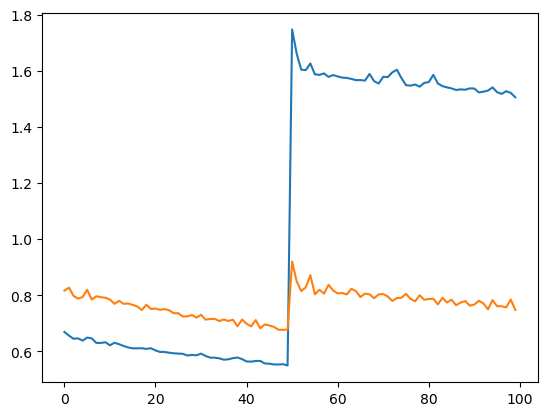

In [70]:
from torch.optim import AdamW

model = S4DMinimal(1,1,1,100)
#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
all_train_loss = []
all_val_loss = []
for num_steps in [1,3]:
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-2,AdamW, nn.MSELoss(), 'cuda',num_steps)
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cuda',num_steps)
    all_train_loss.extend(train_loss)
    all_val_loss.extend(val_loss)

plt.plot(all_train_loss)
plt.plot(all_val_loss)

torch.Size([1, 500, 1]) torch.Size([1, 500, 1])
torch.Size([1, 4, 10, 501])


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


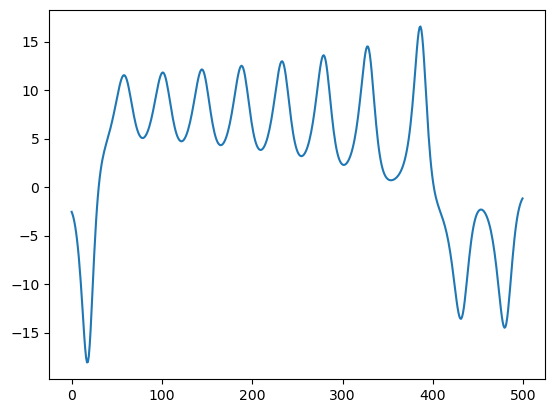

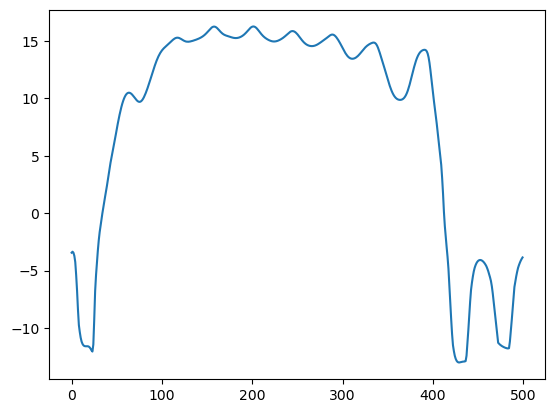

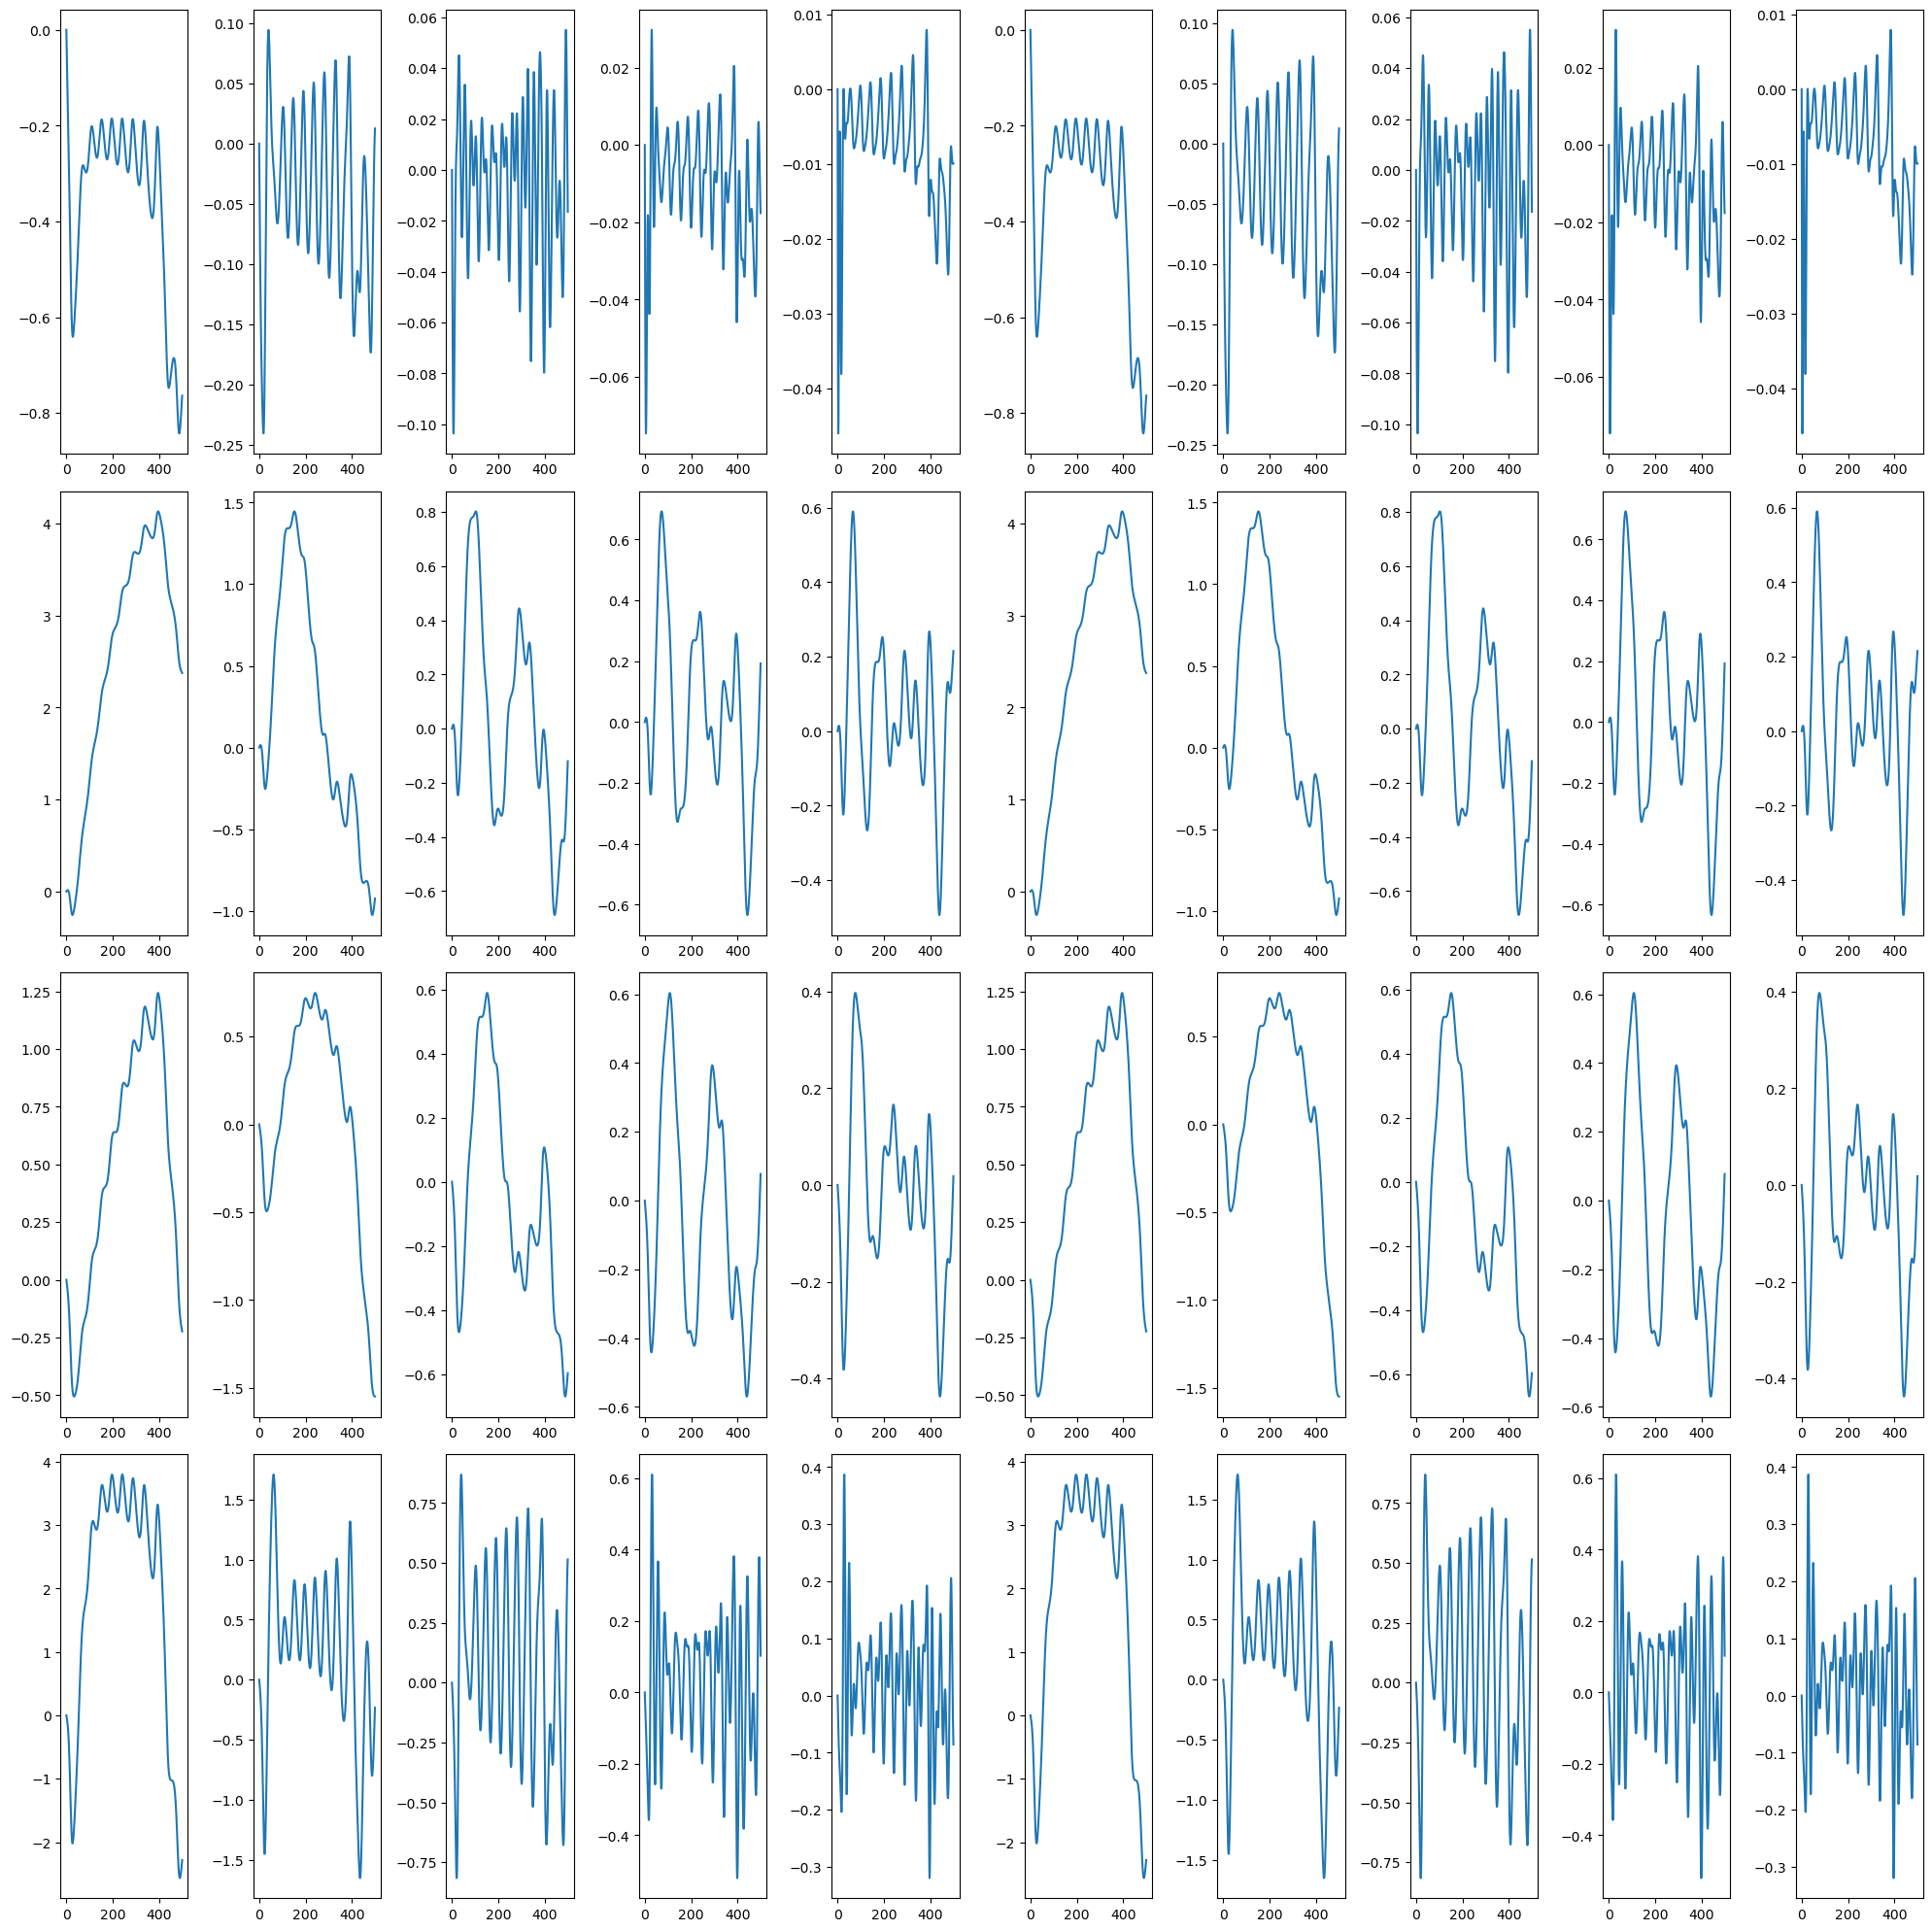

In [72]:
data = next(iter(train_loader))
model.to("cpu")
model.rnn = True
out,hiddens = model(data)

print(data.shape,out.shape)
print(hiddens.shape)
plt.plot(data[0,:,0])
plt.figure()
plt.plot(out[0,:,0].detach().numpy())

fig, ax = plt.subplots(hiddens.shape[1],hiddens.shape[2],figsize=(20,20))
for i in range(hiddens.shape[1]):
    for j in range(hiddens.shape[2]):
        ax[i,j].plot(hiddens[0,i,j].detach().numpy())

plt.tight_layout()